In [2]:
import pandas as pd
import re
import time
import binascii
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
small_dataset = 'data/news_articles_small.csv'
df_small_dataset = pd.read_csv(small_dataset)

In [4]:
"""
    Pre-process data:
        1. convert all to lowercase
        2. remove punctuation
"""

#Convert to lowercase.
df_small_dataset['article'] = df_small_dataset['article'].str.lower()

#Remove punctuation
p = re.compile(r'[^\w\s]+')
df_small_dataset['article'] = [p.sub('', x) for x in df_small_dataset['article'].tolist()]

In [5]:
"""
    Split each document in a list of words

    small_dataset_split = [
        [documentID, document_text]
    ]
"""

small_dataset_split = []
for idx, row in df_small_dataset.iterrows():
    small_dataset_split.append([row[0], row[1].split()])

In [6]:
"""
    createShingles

    To create the shingles for the articles in the dataframe
    @:param small_dataset_split - The dataframe with the articles
"""

def createShingles(small_dataset_split):
#Add shingles with ngram 4
#Source: https://github.com/chrisjmccormick/MinHash/blob/master/runMinHashExample.py
    shingledDocs = {}
    docIds = []

    t0 = time.time()

    totalShingles = 0
    for docId, article in small_dataset_split:
        shingles = set()
        for i in range(0, len(article) - 3):
            shingle = article[i]+ " " + article[i + 1] + " " + article[i + 2] + " " + article[i + 3]

            crc =  binascii.crc32(shingle.encode()) & 0xffffffff
            shingles.add(crc)

        shingledDocs[docId]= shingles
        docIds.append(docId)
        totalShingles = totalShingles + (len(article) - 3)

    t1 = time.time()
    print('Time spent: ', t1-t0)
    return shingledDocs, docIds, totalShingles

In [7]:
"""
    randomHash

    To create random hash functions
    @:param value
    @:param rand_value
"""
def randomHash(value, rand_value):
    return binascii.crc32(value.to_bytes(32, "little")) ^ rand_value

"""
    randomList

    To create random hash functions
    @:param value
    @:param seed
"""
def randomList(n, seed=10):
    random.seed(10)
    l = []
    for i in range(n):
        r = random.getrandbits(32)
        l.append(r)
    return l


In [8]:
shingledDocs, docIds, totalShingles = createShingles(small_dataset_split)

Time spent:  0.251326322555542


In [9]:
print("Generating random hash functions...")
# Number of hash functions
M = 200
random_values = randomList(M)

Generating random hash functions...


In [10]:
"""
    MinHashing from shingles
"""
signatures = []
t0 = time.time()
for doc in docIds:
    signature = []
#     print(shingledDocs[doc])
    for hash_fun in range(M):
        min_value = 1e11
        random_value = random_values[hash_fun]
        # print("random_value ", random_value)
        for shingle in shingledDocs[doc]:
            hash_value = randomHash(shingle, random_value)
#             print("shingle", shingle)
#             print("h_value ", hash_value)
            if hash_value < min_value:
                min_value = hash_value
        signature.append(min_value)
        # print(min_value, " hash number: ", hash_fun, " sign", signature)
    signatures.append(signature)
    # print(signatures)

t1= time.time()

print('Time spent: ', t1-t0)

Time spent:  30.15574049949646


## Method 1


In [11]:
def check_metrics(candidates, results):
    sim = pd.DataFrame(list(candidates), columns=["doc1", "doc2"])
    sim['label'] = 1
    merged = real_sim.merge(sim, left_on=['doc1','doc2'], right_on=['doc1','doc2'], suffixes=['_real', '_calc'], how="left")
    merged = merged.fillna(0)
    metrics = calc_metrics(merged)
    print(" Accuracy: ", metrics[0], "\n Specificity: ", metrics[1],
     "\n Sensitivity: ", metrics[2],"\n Precision: ", metrics[3], 
          "\n combined: ", (2*metrics[2] + 3*metrics[3])/5)
    return float((2*metrics[2] + 3*metrics[3])/5)

In [17]:
real_sim = pd.read_csv("LSH_PlagiarismDetection/real_sim.csv")
real_sim['label'] = np.where(real_sim['sim'] >= 0.8, 1, 0)
real_sim.head()

In [36]:
from numpy import long

"""
    LSH
"""
from itertools import combinations

LARGE_PRIME = 433494437

class LSH:
    def __init__(self, b, r):
        self.buckets = []
        self.counter = 0
        self.b = b
        self.r = r
        self.hash_tables= {}

        self.create_hash_tables()
        # print(self.hash_tables)
        # for i in range(b):
        #     self.buckets.append({})

    def create_hash_tables(self):
        #The hash function must be (s1, s2, p1, p2) sensitive
        #We need to have r hash functions
        #Per band we have a hash table

        # Add hash tables
        for i in range(self.b):
            self.hash_tables[i] = {}

    def hash(self, i, subvec):
        acc = 0
        for value in subvec:
            acc += int(float(value))
        return int((acc * LARGE_PRIME)%(i * self.b))

    def add_to_hash_table(self, i, subvec):
        if subvec not in self.hash_tables[i]:
            self.hash_tables[i][subvec] = []
            self.hash_tables[i][subvec].append(self.counter)
        else:
            self.hash_tables[i][subvec].append(self.counter)

    def make_subvecs(self, signature):
        l = len(signature)
        assert l % self.b == 0
        r = self.r
        # break signature into subvectors
        subvecs = []
        for i in range(0, l, r):
            subvecs.append(signature[i:i+r])
        return np.stack(subvecs)

    def add_hash(self, signature):
        subvecs = self.make_subvecs(signature).astype(str)
        for i, subvec in enumerate(subvecs):
            #Hash every subvector using another hash function
            #and add it to a different hash table that corresponds
            #to that hash function
            hashed_subvec = self.hash(i+1, subvec)
            self.add_to_hash_table(i, hashed_subvec)
        self.counter += 1

    def check_candidates(self):
        candidates = []
        for i in self.hash_tables:
            # print(i)
            keys = self.hash_tables[i].keys()
            for bucket in keys:
                hits = self.hash_tables[i][bucket]
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))
        return set(candidates)

In [13]:
len(signatures)

1000

In [14]:
def parameters(tolerance, r, s2=0.8, p2=0.99):
    s1 = round(s2 - tolerance, 2)
    b = round(np.log(1-p2) / np.log(1-s2**r))
    M = r * b
    p1 = round(1 - (1 - s1 ** r) ** b, 2)
    return (b,r), (s1,s2,p1,p2)

In [15]:
rows = np.linspace(2,10,9)
tolerances = np.linspace(0.05,0.15,3)
ops = []
for i in tolerances:
    for j in rows:
        params, v = parameters(i, j)
        if params[0] * params[1] <= len(signature):
            print("match")
            ops.append([params, v])

match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match


In [16]:
for op in ops:
    print(op[0][0],op[0][1])

len(ops)

5 2.0
6 3.0
9 4.0
12 5.0
15 6.0
20 7.0
25 8.0
5 2.0
6 3.0
9 4.0
12 5.0
15 6.0
20 7.0
25 8.0
5 2.0
6 3.0
9 4.0
12 5.0
15 6.0
20 7.0
25 8.0


21

In [37]:

best_comb = 0
res = []
for op in ops:
    b = int(op[0][0])
    r = int(op[0][1])
    lsh = LSH(b,r)
    l = b * r
    for signature in signatures:
        lsh.add_hash(signature[:l])

    candidate_pairs = lsh.check_candidates()
    print(f"Candidate pairs for n={l} b={b} and r={r}")
    print(f"Number of candidate pairs are {len(candidate_pairs)}")
#     comb = check_metrics(candidate_pairs, real_sim)
#     if comb > best_comb:
#         best_comb = comb
#     res.append([comb, b, r, l])
#     print("="*100)
# print(best_comb)

Candidate pairs for n=10 b=5 and r=2
Number of candidate pairs are 192968
Candidate pairs for n=18 b=6 and r=3
Number of candidate pairs are 175835
Candidate pairs for n=36 b=9 and r=4
Number of candidate pairs are 138723
Candidate pairs for n=60 b=12 and r=5
Number of candidate pairs are 115945
Candidate pairs for n=90 b=15 and r=6
Number of candidate pairs are 101064
Candidate pairs for n=140 b=20 and r=7
Number of candidate pairs are 83139
Candidate pairs for n=200 b=25 and r=8
Number of candidate pairs are 71122
Candidate pairs for n=10 b=5 and r=2
Number of candidate pairs are 192968
Candidate pairs for n=18 b=6 and r=3
Number of candidate pairs are 175835
Candidate pairs for n=36 b=9 and r=4
Number of candidate pairs are 138723
Candidate pairs for n=60 b=12 and r=5
Number of candidate pairs are 115945
Candidate pairs for n=90 b=15 and r=6
Number of candidate pairs are 101064
Candidate pairs for n=140 b=20 and r=7
Number of candidate pairs are 83139
Candidate pairs for n=200 b=25 

In [38]:
# lsh.hash_tables

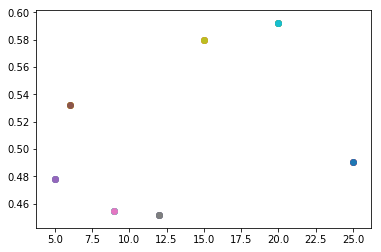

In [100]:
## different b
for sim in res:
#     print(sim[1], sim[0])
    plt.scatter(sim[1], sim[0])
# plt.show()

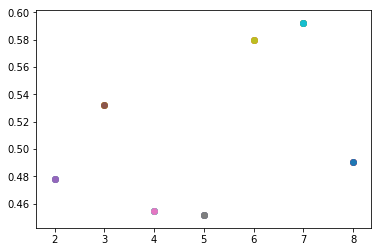

In [101]:
## different r
for sim in res:
#     print(sim[1], sim[0])
    plt.scatter(sim[2], sim[0])
# plt.show()

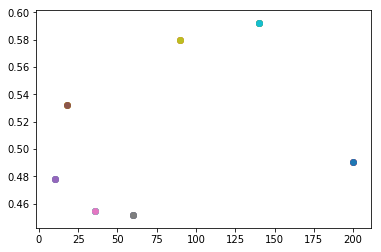

In [102]:
## different l
for sim in res:
    plt.scatter(sim[3], sim[0])

,Unnamed: 0,doc1,doc2,sim,label
0,0,0,1,0.058333,0
1,1,0,2,0.058333,0
2,2,0,3,0.067669,0
3,3,0,4,0.054852,0
4,4,0,5,0.072650,0


## Method 2

In [ ]:
inverted_signs = []

for i in range(len(signatures[0])):
    invert = []
    for signature in signatures:
        invert.append(signature[0])
    inverted_signs.append(invert)


In [35]:
def bandedCandidatePair(col1, col2, b, r):
    """Returns a boolean if the two columns are a candidate pair
    inputs must obey n=len(col1)=len(col2)=b*r"""
    n = len(col1)
    assert(n==b*r)
    assert(n==len(col2))
    truth_array = (col1==col2)
    return any(all(band) for band in np.array_split(truth_array,b))

def bandedCandidatePairs(sig_mat, b, r):
    d = sig_mat.shape[1]
    idxs = range(d)
    cols = [sig_mat[:,i] for i in range(d)]
    pairs = set()
    for (i,col1), (j,col2) in combinations(zip(idxs,cols),2):
        if bandedCandidatePair(col1,col2,b,r):
            pairs.add((i,j))
    return pairs

In [36]:
bs = [5, 10, 20, 25]
n = 100

matrix = np.array(inverted_signs)

for b in bs:
    r=n/b
    pairs = bandedCandidatePairs(matrix, b, r)
    print(f"Candidate pairs for n=100 b={b} and r={100/b}")
    print(f"Number of candidate pairs are {len(pairs)}")

Candidate pairs for n=100 b=5 and r=20.0
Number of candidate pairs are 88
Candidate pairs for n=100 b=10 and r=10.0
Number of candidate pairs are 88
Candidate pairs for n=100 b=20 and r=5.0
Number of candidate pairs are 88
Candidate pairs for n=100 b=25 and r=4.0
Number of candidate pairs are 88


In [37]:
matrix.shape


(100, 1000)

### compare with real results

,Unnamed: 0,doc1,doc2,sim
0,0,0,1,0.058333
1,1,0,2,0.058333
2,2,0,3,0.067669
3,3,0,4,0.054852
4,4,0,5,0.072650


In [44]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix


Confusion Matrix : 
 [[499434     41]
 [     2     23]]
Accuracy:  0.9999139139139139 
 Specificity:  0.9999179138095 
 Sensitivity:  0.92 
 Precision:  0.359375


In [42]:
def calc_metrics(df):

    cm = confusion_matrix(df[['label_real']],df[['label_calc']])
    print('Confusion Matrix : \n', cm)

    total=sum(sum(cm))
    #####from confusion matrix calculate accuracy
    accuracy=(cm[0,0]+cm[1,1])/total
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    precision = cm[1,1]/(cm[0,1]+cm[1,1])
    
    return accuracy, specificity, sensitivity, precision

In [4]:
r = 2
b = 100

S = float((1/b)**(1/r))

print(S)


0.1
